In [31]:
# default_exp data.finance.forecast

In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from libs import is_lib_exists

In [35]:
required_libs = [ ("numpy", "numpy"),
                  ("pandas", "pandas"),
                  ("seaborn", "seaborn"),
                  ("matplotlib", "matplotlib"),
                  ("investpy", "investpy"),
                  ("dateutil", "python-dateutil"),
                  ("fbprophet", "fbprophet"),
                ]

In [36]:
for (clz,lib) in required_libs:
    if not is_lib_exists(clz):
        print(f"Installing {lib}")
        !pip install -qq {lib}
    else:
        print(f"{lib} exists")

numpy exists
pandas exists
seaborn exists
matplotlib exists
investpy exists
python-dateutil exists
fbprophet exists


In [95]:
#export
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import investpy
from pathlib import Path
from dateutil.relativedelta import *
from datetime import *
import calendar
import traceback
from ts_utils import *

In [96]:
%matplotlib inline

In [51]:
#%quickref
#%magic
#%env

In [40]:
from IPython.display import display, Image

# Finance Data

> Functionality to gather finance data.

The classes here provide bases classes used to gather finance data for model training.

In [42]:
#hide
from nbdev.showdoc import *

In [43]:
# Dataset path
DATASET_PATH = Path("../../data")  

# Country to analyze
COUNTRY = "malaysia"

# Dataset
DATASET = DATASET_PATH/f"ftse_klse_investing.csv"

# Stocks summary
DATASET_STOCKS_SUMMARY = DATASET_PATH/f"stocks_summary.csv"

## FTSE KLSE

In [303]:
# Retrieve stock components
dataset = investpy.get_stocks(country=COUNTRY)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    929 non-null    object
 1   name       929 non-null    object
 2   full_name  929 non-null    object
 3   isin       929 non-null    object
 4   currency   929 non-null    object
 5   symbol     929 non-null    object
dtypes: object(6)
memory usage: 43.7+ KB


In [304]:
# Save the dataset
dataset.to_csv(DATASET, index=False)

# dataset = pd.read_csv(DATASET, header=0, sep=',', quotechar='"')

In [305]:
print(f"Number of stock - {len(dataset)}")
display(dataset.head(3))

Number of stock - 929


country               name                        full_name          isin  \
0  malaysia  Media Chinese Int  Media Chinese International Ltd  BMG5959D1048   
1  malaysia               AMMB                AMMB Holdings Bhd  MYL1015OO006   
2  malaysia         CIMB Group          CIMB Group Holdings Bhd  MYL1023OO000   

  currency symbol  
0      MYR   MDCH  
1      MYR   AMMB  
2      MYR   CIMB

In [306]:
FROM_DATE = '1/3/2020'

TO_DATE = datetime.strftime(date.today(), '%d/%m/%Y')
#TO_DATE="30/9/2020"

TEST_DATE = "2020-10-01"

TEST_STOCK_CODE="MBBM"

print(FROM_DATE, TO_DATE)

1/3/2020 14/10/2020


In [307]:
df = investpy.get_stock_historical_data(stock=TEST_STOCK_CODE,
                                        country=COUNTRY,
                                        from_date=FROM_DATE,
                                        to_date=TO_DATE)
df.reset_index(inplace=True)
df.tail()

Date  Open  High   Low  Close   Volume Currency
149 2020-10-08  7.17  7.30  7.11   7.30  3918200      MYR
150 2020-10-09  7.26  7.40  7.20   7.40  4985700      MYR
151 2020-10-12  7.37  7.38  7.24   7.35  3319800      MYR
152 2020-10-13  7.30  7.39  7.25   7.35  2762900      MYR
153 2020-10-14  7.35  7.35  7.24   7.24  5637500      MYR

In [308]:
ts = df[['Date','Close']].copy()
ts.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
ts.set_index(['ds'], inplace=True)
ts = ts['y']
ts.name = TEST_STOCK_CODE
ts

ds
2020-03-02    8.39
2020-03-03    8.41
2020-03-04    8.47
2020-03-05    8.53
2020-03-06    8.50
              ... 
2020-10-08    7.30
2020-10-09    7.40
2020-10-12    7.35
2020-10-13    7.35
2020-10-14    7.24
Name: MBBM, Length: 154, dtype: float64

In [257]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))
w = 30
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

population --> len: 153 | mean: 8  | std: 0
moving --> len: 30  | mean: 7  | std: 0


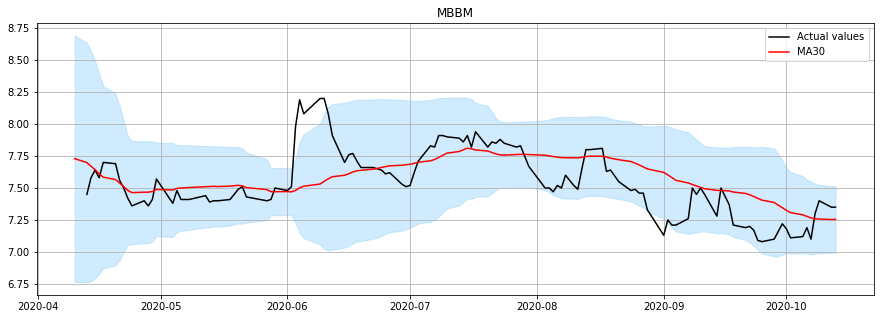

In [258]:
plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

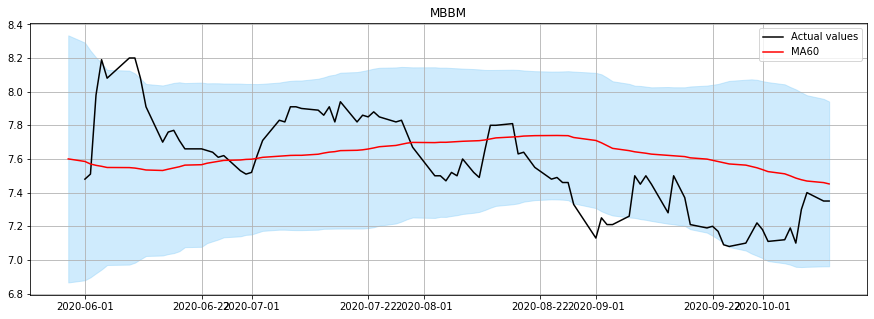

In [259]:
# looks like a soft downtrend, it should be clear with a window of 1 year
plot_ts(ts, plot_ma=True, plot_intervals=True, window=60, figsize=(15,5))

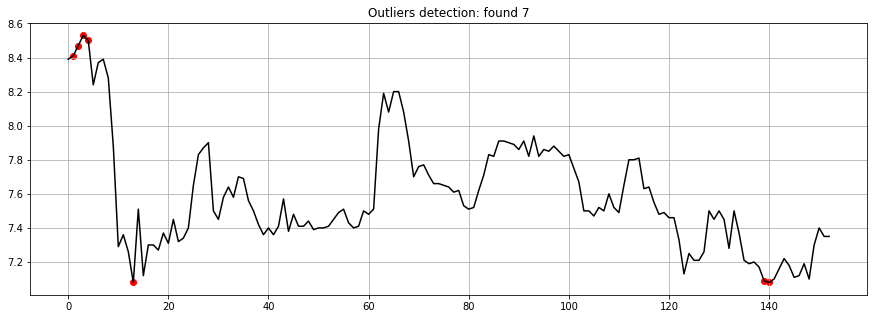

In [260]:
# outliers
dtf_outliers = find_outliers(ts, perc=0.05, figsize=(15,5))

In [261]:
# Remove outliers?
# ts_clean = remove_outliers(ts, outliers_idx=dtf_outliers[dtf_outliers["outlier"]==1].index, figsize=(15,5))

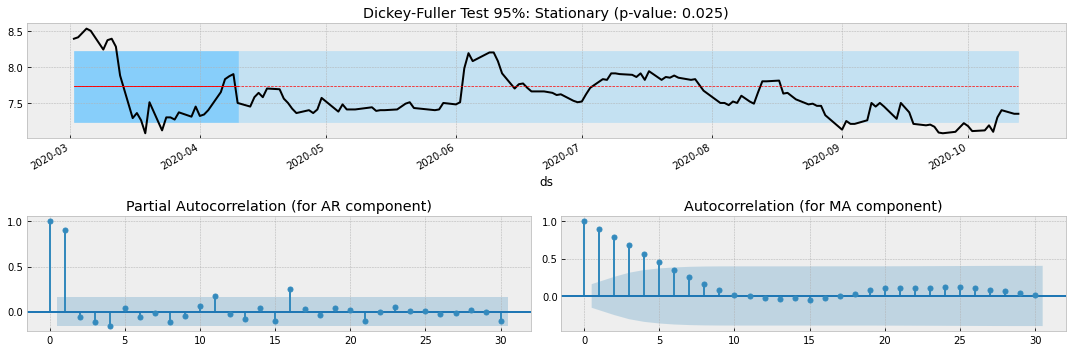

In [262]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=w, figsize=(15,5))

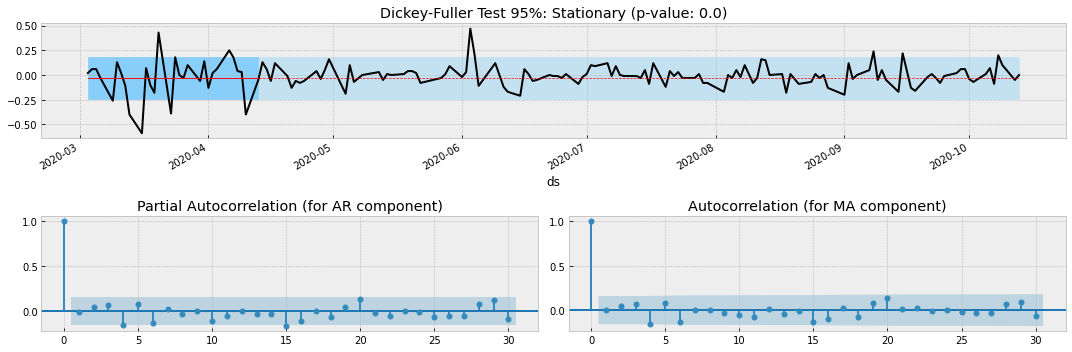

In [263]:
# try with differentiating ts
test_stationarity_acf_pacf(diff_ts(ts, order=1), sample=0.20, maxlag=30, figsize=(15,5))

/Users/mengwangk/workspace/development/investor/investor/experiment/science/nbdev/nbs/ts_utils.py:138: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = smt.seasonal_decompose(ts, freq=s)


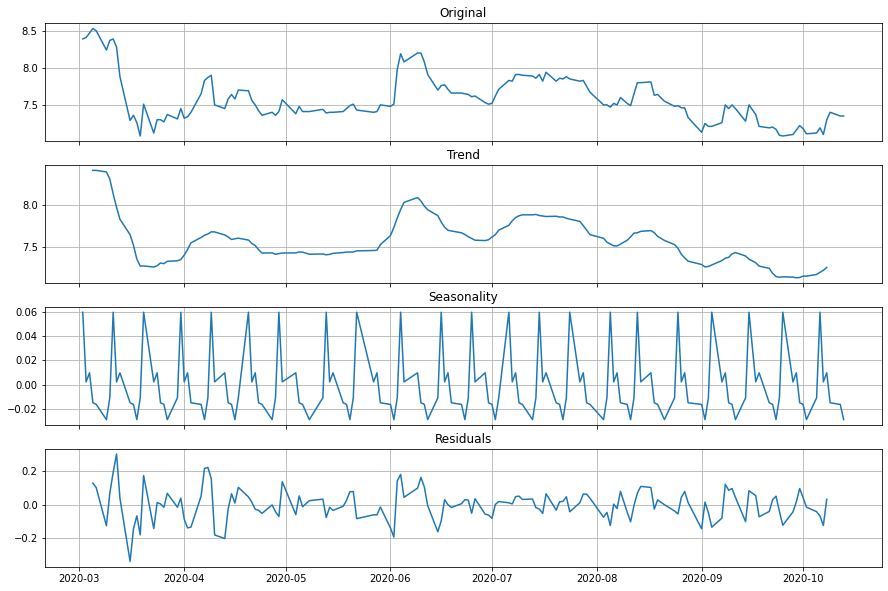

In [264]:
# seasonality
dic_decomposed = decompose_ts(ts, s=7, figsize=(15,10))

--- splitting at index:  144 | 2020-10-01 00:00:00 | test size: 0.06  ---


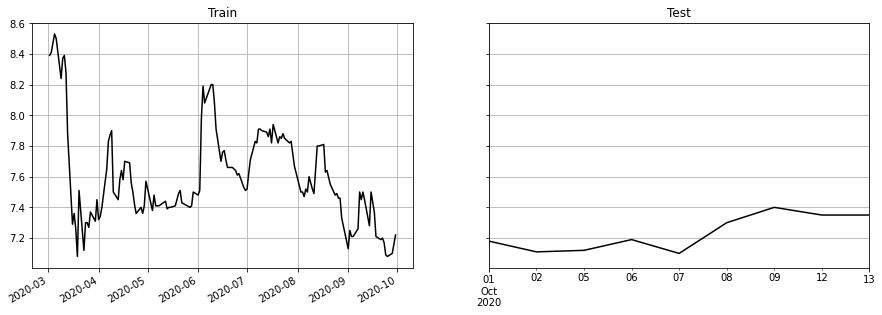

(144, 9)

In [265]:
# Pre-processing
ts_train, ts_test = split_train_test(ts, exog=None, test=TEST_DATE, plot=True, figsize=(15,5))
len(ts_train), len(ts_test)

In [266]:
dtf_train = ts_train.reset_index().rename(columns={TEST_STOCK_CODE:'y'})
dtf_test = ts_test.reset_index().rename(columns={TEST_STOCK_CODE:'y'})

dtf_train.tail()

ds     y
139 2020-09-24  7.09
140 2020-09-25  7.08
141 2020-09-28  7.10
142 2020-09-29  7.16
143 2020-09-30  7.22

In [267]:
dtf_holidays = None

In [268]:
model = Prophet()
#model = Prophet(daily_seasonality=True, yearly_seasonality=False)
#model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
#                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
#                holidays=dtf_holidays, interval_width=0.80)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


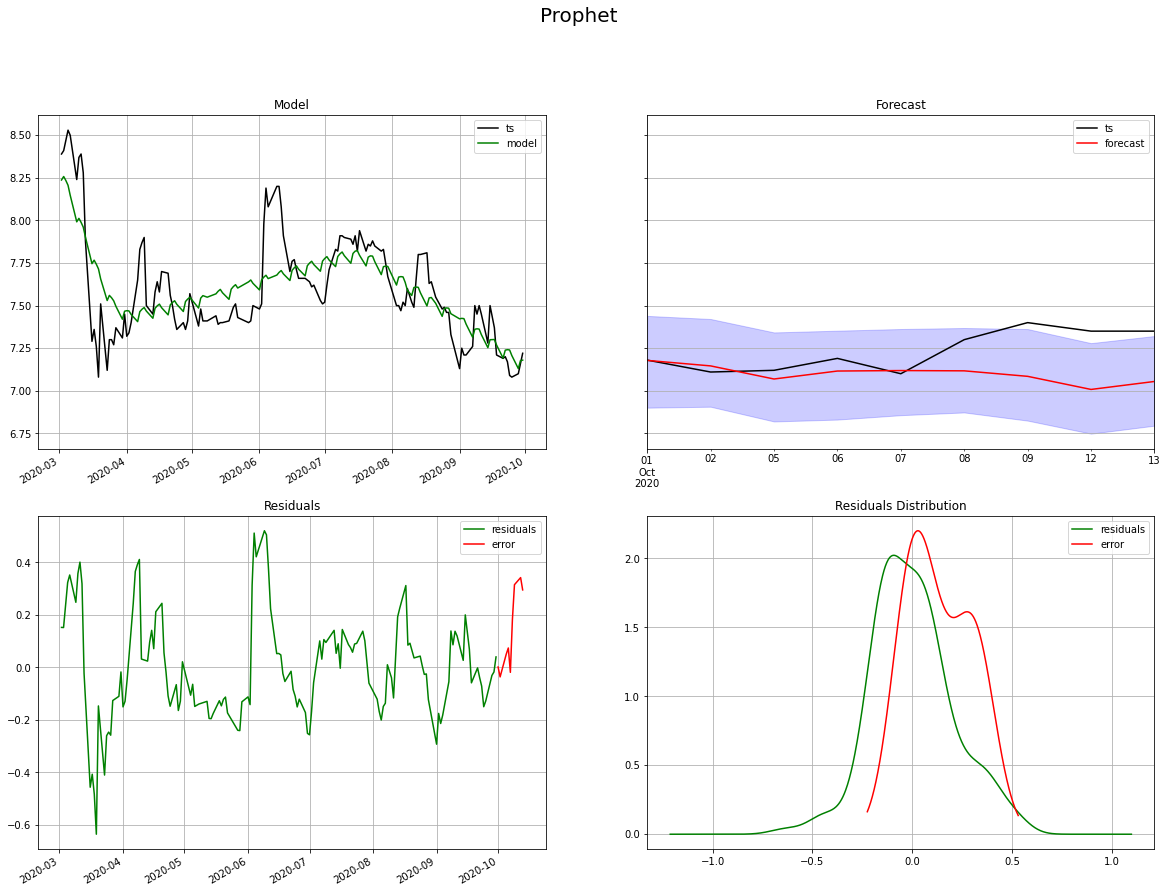

Training --> Residuals mean: 0.0  | std: 0.0
Test --> Error mean: 0.0  | std: 0.0  | mae: 0.0  | mape: 2.0 %  | mse: 0.0  | rmse: 0.0


In [269]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, freq="D", figsize=(20,15))

In [270]:
# forecast
dtf = ts.reset_index().rename(columns={"date":"ds", TEST_STOCK_CODE:"y"})
dtf.tail()

ds     y
148 2020-10-07  7.10
149 2020-10-08  7.30
150 2020-10-09  7.40
151 2020-10-12  7.35
152 2020-10-13  7.35

In [289]:
model = Prophet()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--- generating index date --> start: 2020-10-14 00:00:00 | end: 2020-10-30 00:00:00 | len: 17 ---


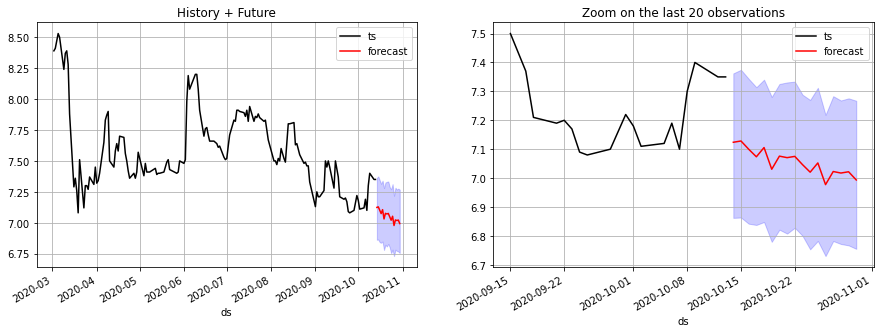

In [290]:
future = forecast_prophet(dtf, model, end="2020-10-30", freq="D", zoom=20, figsize=(15,5))

In [285]:
ts.min()

7.08

## Quick test

In [310]:
df = ts.reset_index().rename(columns={"date":"ds", TEST_STOCK_CODE:"y"})
df

ds     y
0   2020-03-02  8.39
1   2020-03-03  8.41
2   2020-03-04  8.47
3   2020-03-05  8.53
4   2020-03-06  8.50
..         ...   ...
149 2020-10-08  7.30
150 2020-10-09  7.40
151 2020-10-12  7.35
152 2020-10-13  7.35
153 2020-10-14  7.24

[154 rows x 2 columns]

In [312]:
df_train = df[df['ds'] < TEST_DATE]
df_test = df[df['ds'] >= TEST_DATE]
df_test.tail()

ds     y
149 2020-10-08  7.30
150 2020-10-09  7.40
151 2020-10-12  7.35
152 2020-10-13  7.35
153 2020-10-14  7.24

In [313]:
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [314]:
future = df_test.drop(columns=['y'])
future

ds
144 2020-10-01
145 2020-10-02
146 2020-10-05
147 2020-10-06
148 2020-10-07
149 2020-10-08
150 2020-10-09
151 2020-10-12
152 2020-10-13
153 2020-10-14

In [315]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
5 2020-10-08  7.116959    6.881256    7.375671
6 2020-10-09  7.084670    6.805692    7.336776
7 2020-10-12  7.007727    6.740103    7.276676
8 2020-10-13  7.054531    6.804333    7.315514
9 2020-10-14  7.057298    6.799367    7.320055

In [316]:
# for next 60 days
future = m.make_future_dataframe(periods=60)
future.tail()

ds
199 2020-11-25
200 2020-11-26
201 2020-11-27
202 2020-11-28
203 2020-11-29

In [318]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(70)

ds      yhat  yhat_lower  yhat_upper
134 2020-09-17  7.300822    7.034617    7.561330
135 2020-09-18  7.268533    7.015078    7.510681
136 2020-09-21  7.191589    6.943989    7.447595
137 2020-09-22  7.238394    6.977152    7.494821
138 2020-09-23  7.241160    6.978880    7.503801
..         ...       ...         ...         ...
199 2020-11-25  6.689573    6.310134    7.073864
200 2020-11-26  6.687947    6.320094    7.075304
201 2020-11-27  6.655658    6.257888    7.043998
202 2020-11-28  6.609022    6.233665    7.050440
203 2020-11-29  6.675275    6.266963    7.093667

[70 rows x 4 columns]

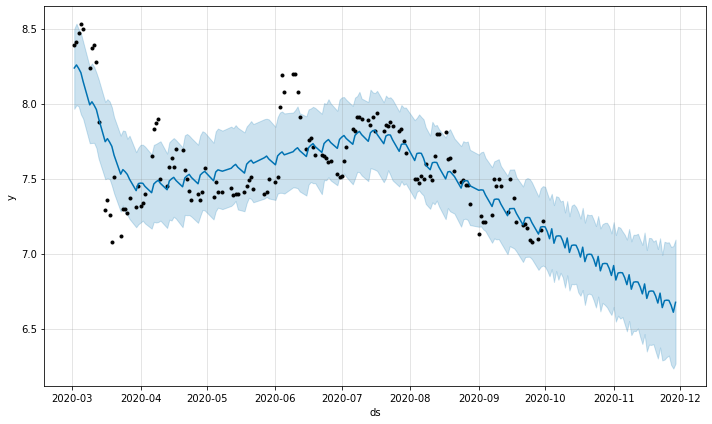

In [319]:
# Python
fig1 = m.plot(forecast)

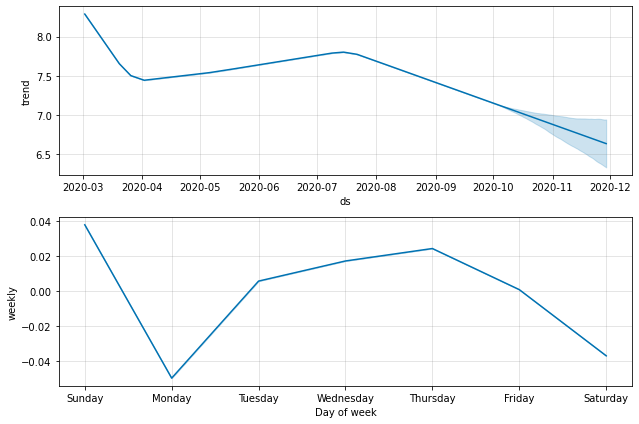

In [320]:
fig2 = m.plot_components(forecast)

In [321]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [322]:
plot_components_plotly(m, forecast)